In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
from collections import defaultdict
import requests
import ipyparallel as ipp
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import r2_score
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
import itertools
import random

In [2]:
def fetch_counts_for_year(year):
    counts_for_year = defaultdict(int)
    offset = 0
    limit = 10000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts_for_year[site_code] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break
    return counts_for_year

rc = ipp.Client()
dview = rc[:]

with dview.sync_imports():
    import requests
    from collections import defaultdict

dview.push({'fetch_counts_for_year': fetch_counts_for_year})

years = list(range(2000, 2025))

async_results = dview.map_async(fetch_counts_for_year, years)
results = async_results.get()

counts = defaultdict(lambda: defaultdict(int))
for year, year_counts in zip(years, results):
    for site_code, count in year_counts.items():
        counts[site_code][year] = count

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

importing requests on engine(s)
importing defaultdict from collections on engine(s)


In [3]:
columns_to_keep = ['site_code'] + [
    col for col in obs_df.columns 
    if col.startswith('observations_') and int(col.split('_')[1]) >= 2008
]

ov25 = obs_df[columns_to_keep]

In [4]:
observation_columns = [col for col in ov25.columns if col.startswith('observations_')]
ov25 = ov25[ov25[observation_columns].ge(25).all(axis=1)]

In [5]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={site_code} {year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

In [6]:
rc = ipp.Client(timeout=1200)
dview = rc[:]

dview.push({
    'fetch_all_records': fetch_all_records,
    'get_readings_for_site': get_readings_for_site
})

dview.execute("""
import pandas as pd
import numpy as np
import requests
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
""")

years = list(range(2008, 2025))
site_codes = ov25['site_code'].unique()

def load_site_data(site_code, years):
    return get_readings_for_site(site_code, years)

site_data = list(tqdm(
    dview.imap(load_site_data, site_codes, [years]*len(site_codes)),
    total=len(site_codes),
    desc="Loading site data"
))

Loading site data: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s]


In [31]:
data_dict = dict(zip(site_codes, site_data))
dview.push({'data_dict': data_dict})

def process_site(site_code, years, cps, sps):
    try:
        df = data_dict.get(site_code)
        if df is None or df.empty:
            return None

        df['msmt_date'] = pd.to_datetime(df['msmt_date'])
        df = df[['msmt_date', 'wlm_rpe']].rename(columns={'msmt_date': 'ds', 'wlm_rpe': 'y'})
        df = df.sort_values('ds')

        model = Prophet(changepoint_prior_scale=cps,
                        seasonality_prior_scale=sps,
                        seasonality_mode='additive',
                        yearly_seasonality=True)
        model.fit(df)
        
        cv_results = cross_validation(model,
                                      initial='730 days',
                                      period='90 days',
                                      horizon='90 days',
                                      parallel="processes")
        metrics_df = performance_metrics(cv_results)
        avg_metrics = metrics_df.mean()
        
        y_full = df['y'].values
        scale_mase = np.mean(np.abs(np.diff(y_full)))
        scale_rmsse = np.mean((np.diff(y_full))**2)
        
        mae_cv = np.mean(np.abs(cv_results['y'] - cv_results['yhat']))
        mse_cv = np.mean((cv_results['y'] - cv_results['yhat'])**2)
        
        mase_val = mae_cv / scale_mase if scale_mase != 0 else np.nan
        rmsse_val = np.sqrt(mse_cv / scale_rmsse) if scale_rmsse != 0 else np.nan
        
        avg_metrics_dict = avg_metrics.to_dict()
        avg_metrics_dict['mase'] = mase_val
        avg_metrics_dict['rmsse'] = rmsse_val
        
        return avg_metrics_dict
    except Exception as e:
        return None

dview.push({'process_site': process_site})

param_grid = {
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 10.0]
}

CHUNK_SIZE = 5

aggregated_results = []
grid = list(itertools.product(param_grid['changepoint_prior_scale'],
                              param_grid['seasonality_prior_scale']))

for cps, sps in grid:
    collected = {}
    n_valid = 0
    
    for start_idx in tqdm(range(0, len(site_codes), CHUNK_SIZE)):
        chunk = site_codes[start_idx : start_idx + CHUNK_SIZE]

        async_results = dview.map_async(
            process_site,
            chunk,
            [years] * len(chunk),
            [cps]   * len(chunk),
            [sps]   * len(chunk)
        )

        site_results = async_results.get()
        for res in site_results:
            if res is not None:
                n_valid += 1
                for key, value in res.items():
                    collected.setdefault(key, []).append(value)

    if n_valid > 0:
        avg_metrics = {key: np.mean(vals) for key, vals in collected.items()}
        avg_metrics.update({
            'changepoint_prior_scale': cps,
            'seasonality_prior_scale': sps,
            'seasonality_mode': 'additive',
            'n_sites': n_valid
        })
        aggregated_results.append(avg_metrics)
    else:
        print(f"No valid results for parameters: cps={cps}, sps={sps}")

results_df = pd.DataFrame(aggregated_results)
results_df = results_df.sort_values('mase')
results_df.to_csv("prophet_train.csv", index=False)

print("Aggregated Cross Validation Grid Search Results (averaged over sites):")
print(results_df)
print("\nBest Parameters based on aggregated MASE:")
print(results_df.iloc[0])

100%|██████████| 37/37 [08:51<00:00, 14.36s/it]

Aggregated Cross Validation Grid Search Results (averaged over sites):
                      horizon       mse      rmse       mae      mape  \
0  49 days 14:43:09.417757729  0.011480  0.038250  0.012461  0.000292   
1  49 days 14:43:09.417757729  0.011552  0.038475  0.012490  0.000293   
2  49 days 14:43:09.417757729  0.011573  0.038459  0.012465  0.000292   
3  49 days 14:43:09.417757729  0.011597  0.038505  0.012497  0.000293   
4  49 days 14:43:09.417757729  0.011606  0.038543  0.012501  0.000293   
5  49 days 14:43:09.417757729  0.011166  0.037792  0.011919  0.000275   
6  49 days 14:43:09.417757729  0.011455  0.038307  0.011953  0.000276   
7  49 days 14:43:09.417757729  0.011472  0.038326  0.011950  0.000276   
8  49 days 14:43:09.417757729  0.011466  0.038317  0.011954  0.000276   
9  49 days 14:43:09.417757729  0.011544  0.038420  0.011960  0.000277   
10 49 days 14:43:09.417757729  0.011124  0.037749  0.011833  0.000273   
11 49 days 14:43:09.417757729  0.011471  0.038371  0.

In [9]:
def mase_quarterly_average(
    df: pd.DataFrame,
    date_col: str = "msmt_date",
    observed_col: str = "y",
    predicted_col: str = "yhat"
) -> float:
    """
    Calculate a quarterly-based MASE, where the naive (reference) forecast
    for each quarter of year t is the average GWE from that same quarter
    in year t-1.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least:
            - a datetime column for the measurement date
            - an observed GWE column
            - a Prophet (or model) forecast column
    date_col : str
        Column name for the measurement date (must be datetime or convertible).
    observed_col : str
        Column name for the observed GWE values.
    predicted_col : str
        Column name for the model/Prophet forecast values.

    Returns
    -------
    float
        The MASE value (mean absolute scaled error).
    """

    # Copy to avoid mutating the original DataFrame
    df_local = df.copy()
    
    # Ensure date_col is datetime
    df_local[date_col] = pd.to_datetime(df_local[date_col])

    # Extract year and quarter
    df_local["year"] = df_local[date_col].dt.year
    df_local["quarter"] = df_local[date_col].dt.quarter

    # 1) Compute the average observed GWE by [year, quarter]
    avg_by_q = (
        df_local
        .groupby(["year", "quarter"], as_index=False)
        [observed_col]
        .mean()
        .rename(columns={observed_col: "avg_gwe"})
    )

    # 2) Merge in the naive forecast:
    #    For each row (year, quarter), find the average from (year-1, quarter)
    #    i.e. "quarterly average" from the previous year
    df_local = pd.merge(
        df_local,
        avg_by_q.rename(columns={"year": "year_ref", "avg_gwe": "naive_forecast"}),
        how="left",
        left_on=["year", "quarter"],
        right_on=["year_ref", "quarter"]
    )

    # Because we merged on year == year_ref, we now adjust 'naive_forecast' 
    # to be the average from the previous year by shifting the year by 1
    # We'll do that by merging with year-1, so we actually need to align:
    df_local["year_lag"] = df_local["year"] - 1

    # Drop the intermediate columns from the first merge
    df_local.drop(["year_ref"], axis=1, inplace=True)

    # Actually do the proper "previous year" merge
    #   left_on = [year_lag, quarter]
    #   right_on = [year, quarter]
    # We only want the "avg_gwe" from the previous year's groupby.
    # So let's do a second pass with the original avg_by_q data.
    df_local = pd.merge(
        df_local,
        avg_by_q.rename(columns={"avg_gwe": "naive_forecast"}),
        how="left",
        left_on=["year_lag", "quarter"],
        right_on=["year", "quarter"],
        suffixes=("", "_drop")  # to avoid name collision
    )

    # Now 'naive_forecast' column should contain the average from the previous year's same quarter
    # We don't need the extra 'year_drop' column from the right
    df_local.drop(["year_drop"], axis=1, inplace=True, errors="ignore")

    # 3) Calculate absolute errors for Prophet forecast
    df_local["abs_err_prophet"] = (df_local[observed_col] - df_local[predicted_col]).abs()

    # 4) Calculate absolute errors for naive forecast
    df_local["abs_err_naive"] = (df_local[observed_col] - df_local["naive_forecast"]).abs()

    # Filter out any rows where naive_forecast is missing (for instance, earliest year)
    df_local_valid = df_local.dropna(subset=["abs_err_naive", "abs_err_prophet"])

    if len(df_local_valid) == 0:
        raise ValueError("No valid rows to compute MASE. Possibly not enough historical data.")

    # 5) Compute MASE
    mae_prophet = df_local_valid["abs_err_prophet"].mean()
    mae_naive   = df_local_valid["abs_err_naive"].mean()

    mase_value = mae_prophet / mae_naive

    return mase_value

In [15]:
data_dict = dict(zip(site_codes, site_data))

In [16]:
def metrics_mase_r2_q3_q4(
    df: pd.DataFrame,
    date_col: str = "ds",
    observed_col: str = "y",
    predicted_col: str = "yhat"
) -> dict:
    """
    Calculate two metrics, restricted to Q3 (quarter=3) and Q4 (quarter=4) data:
      1) MASE: Mean Absolute Scaled Error, using a quarterly-average naive forecast
               from the same quarter of the prior year.
      2) R^2:  Coefficient of determination on the Q3/Q4 subset.

    Returns a dictionary: {"MASE_Q3_Q4": float, "R2_Q3_Q4": float or NaN}.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns:
          - date_col (datetime),
          - observed_col (float),
          - predicted_col (float).
    date_col : str, default "ds"
        Column name containing the datetime.
    observed_col : str, default "y"
        Column name containing observed values.
    predicted_col : str, default "yhat"
        Column name containing model forecast values.

    Returns
    -------
    dict
        {
          "MASE_Q3_Q4": <float or np.nan>,
          "R2_Q3_Q4":   <float or np.nan>
        }
    """

    # Copy so we don't mutate original
    df_local = df.copy()
    df_local[date_col] = pd.to_datetime(df_local[date_col])

    # Extract year and quarter
    df_local["year"] = df_local[date_col].dt.year
    df_local["quarter"] = df_local[date_col].dt.quarter

    # 1) Compute average observed by (year, quarter)
    avg_by_q = (
        df_local
        .groupby(["year", "quarter"], as_index=False)[observed_col]
        .mean()
        .rename(columns={observed_col: "quarterly_avg"})
    )

    # 2) Naive forecast: average from same quarter in the previous year
    df_local["year_lag"] = df_local["year"] - 1

    df_local = pd.merge(
        df_local,
        avg_by_q.rename(columns={
            "year": "year_lag",
            "quarterly_avg": "naive_forecast"
        }),
        on=["year_lag", "quarter"],
        how="left"
    )

    # 3) Calculate absolute errors, squared errors
    df_local["abs_err_prophet"] = (df_local[observed_col] - df_local[predicted_col]).abs()
    df_local["abs_err_naive"]   = (df_local[observed_col] - df_local["naive_forecast"]).abs()
    df_local["sq_err_prophet"]  = (df_local[observed_col] - df_local[predicted_col])**2

    # 4) Filter to Q3/Q4 only
    df_q3_q4 = df_local[df_local["quarter"].isin([3, 4])].dropna(
        subset=["abs_err_prophet", "abs_err_naive", "sq_err_prophet"]
    )

    if df_q3_q4.empty:
        return {"MASE_Q3_Q4": np.nan, "R2_Q3_Q4": np.nan}

    # ---------------- MASE ----------------
    mae_prophet = df_q3_q4["abs_err_prophet"].mean()
    mae_naive   = df_q3_q4["abs_err_naive"].mean()
    mase_val    = mae_prophet / mae_naive if mae_naive != 0 else np.nan

    # ---------------- R^2 ----------------
    # R^2 = 1 - (SS_res / SS_tot), restricted to Q3/Q4
    #  SS_res = sum((y - yhat)^2)
    #  SS_tot = sum((y - mean(y))^2)
    obs_q3_q4 = df_q3_q4[observed_col].values
    pred_q3_q4 = df_q3_q4[predicted_col].values

    ss_res = np.sum((obs_q3_q4 - pred_q3_q4) ** 2)
    y_mean = np.mean(obs_q3_q4)
    ss_tot = np.sum((obs_q3_q4 - y_mean) ** 2)

    if ss_tot == 0:
        r2_val = np.nan
    else:
        r2_val = 1 - (ss_res / ss_tot)

    return {"MASE_Q3_Q4": mase_val, "R2_Q3_Q4": r2_val}


def prophet_metrics_for_well_q3_q4(well_id: str, df_well: pd.DataFrame):
    """
    For a single well's time-series:
      - Rename columns to Prophet format ('ds', 'y'),
      - Fit a Prophet model in-sample,
      - Merge the model's forecast,
      - Compute the Q3/Q4 MASE & R^2 using a quarterly-average naive baseline.

    Returns
    -------
    dict
        {
          "well_id":      well_id,
          "MASE_Q3_Q4":   <float or np.nan>,
          "R2_Q3_Q4":     <float or np.nan>
        }
    """
    # 1) Rename columns for Prophet
    df_local = df_well.copy()
    df_local.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    df_local["ds"] = pd.to_datetime(df_local["ds"])
    df_local.sort_values("ds", inplace=True)

    # 2) Fit Prophet in-sample
    m = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    model.fit(df_local[["ds", "y"]])

    # 3) Make an in-sample forecast
    forecast = model.predict(df_local[["ds"]])

    # 4) Merge forecast with observed data
    df_merged = pd.merge(
        df_local,
        forecast[["ds", "yhat"]],
        on="ds",
        how="left"
    )

    # 5) Compute Q3/Q4 metrics
    metrics_dict = metrics_mase_r2_q3_q4(
        df_merged,
        date_col="ds",
        observed_col="y",
        predicted_col="yhat"
    )

    return {
        "site_code": well_id,
        "MASE_Q3_Q4": metrics_dict["MASE_Q3_Q4"],
        "R2_Q3_Q4":   metrics_dict["R2_Q3_Q4"],
    }

In [17]:
rc = ipp.Client()               # connect (assumes 'ipcluster start' or similar)
lview = rc.load_balanced_view() # a load-balanced view

# 2) Ensure each engine has required imports
rc[:].execute("import pandas as pd; import numpy as np; from prophet import Prophet")

# 3) Push function definitions to each engine
rc[:].push({'metrics_mase_r2_q3_q4': metrics_mase_r2_q3_q4})
rc[:].push({'prophet_metrics_for_well_q3_q4': prophet_metrics_for_well_q3_q4})


def run_prophet_and_compute_mase_r2_q3_q4_parallel(data_dict):
    """
    data_dict: dict
       Keys = well_ids (str)
       Values = DataFrames with columns ["msmt_date", "gwe"] for each well.
    
    Returns
    -------
    pd.DataFrame
       Columns: [well_id, MASE_Q3_Q4, R2_Q3_Q4]
    """
    async_results = []
    for well_id, df_well in data_dict.items():
        # Submit each well's job to the cluster
        ar = lview.apply_async(prophet_metrics_for_well_q3_q4, well_id, df_well)
        async_results.append(ar)

    # Collect results
    results_list = [res.get() for res in async_results]
    return pd.DataFrame(results_list)

In [ ]:
validate_q3q4 = run_prophet_and_compute_mase_r2_q3_q4_parallel(data_dict)

In [32]:
validate_q3q4.describe()

,MASE_Q3_Q4,R2_Q3_Q4
count,181.000000,181.000000
mean,0.487806,0.761980
std,0.158080,0.178112
min,0.188828,0.042905
25%,0.372519,0.646542
50%,0.478910,0.809586
75%,0.584139,0.912804
max,0.924753,0.995165


In [34]:
validate_obs = pd.merge(validate_q3q4, ov25, on="site_code", how="inner")

In [52]:
obs_cols = [col for col in validate_obs.columns if col.startswith("observations_")]
validate_obs["observations_min"] = validate_obs[obs_cols].min(axis=1)

In [53]:
validate_obs

,MASE_Q3_Q4,R2_Q3_Q4,site_code,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024,observations_2008,observations_2010,...,observations_2013,observations_2014,observations_2016,observations_2017,observations_2018,observations_2019,observations_2015,observations_median,obs_median_bin,observations_min
0,0.785874,0.412611,396468N1217263W003,312,369,368,369,295,371,368,...,368,372,375,369,370,369,371,295.0,"(214.0, 338.0]",295.0
1,0.252995,0.991372,399740N1219748W001,219,368,368,368,295,370,368,...,367,369,369,368,368,366,366,219.0,"(214.0, 338.0]",219.0
2,0.468045,0.953079,399733N1220069W002,369,368,368,368,295,370,236,...,367,369,221,152,367,365,369,152.0,"(115.0, 156.0]",152.0
3,0.226557,0.959953,395812N1217026W002,370,370,83,290,368,370,369,...,369,371,84,156,354,370,133,83.0,"(79.0, 115.0]",83.0
4,0.444678,0.953038,399733N1220069W001,369,310,368,368,273,370,236,...,367,369,221,291,368,365,367,221.0,"(214.0, 338.0]",221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.283305,0.906548,396468N1217263W004,370,227,368,369,295,371,368,...,163,159,337,114,370,369,370,114.0,"(79.0, 115.0]",114.0
177,0.401582,0.753454,398028N1220294W001,370,290,228,313,378,184,369,...,390,373,374,348,370,236,438,184.0,"(156.0, 214.0]",184.0
178,0.536643,0.886083,398028N1220294W003,370,369,299,274,310,184,369,...,389,372,374,319,299,369,443,184.0,"(156.0, 214.0]",184.0
179,0.379863,0.920005,398028N1220294W002,370,369,148,312,374,184,369,...,390,373,374,369,370,369,440,148.0,"(115.0, 156.0]",148.0


In [54]:
validate_obs["obs_min_bin"] = pd.qcut(
    validate_obs["observations_min"], 
    q=5, 
    duplicates="drop"  # in case of duplicate edges
)

In [57]:
bucketed_results = (
    validate_obs
    .groupby("obs_min_bin", dropna=False)
    .agg(
        MASE_Q3_Q4=("MASE_Q3_Q4", "mean"),
        R2_Q3_Q4=("R2_Q3_Q4", "mean"),
        count=("MASE_Q3_Q4", "size")   # or use any column for .size()
    )
    .reset_index()
)

/tmp/ipykernel_394689/3692346044.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("obs_min_bin", dropna=False)


In [60]:
overall_mase = validate_obs["MASE_Q3_Q4"].mean()
overall_r2   = validate_obs["R2_Q3_Q4"].mean()
overall_count = len(validate_obs)

# 5) Create a row for "All" with overall stats
overall_row = pd.DataFrame({
    "obs_min_bin": ["All"],
    "MASE_Q3_Q4": [overall_mase],
    "R2_Q3_Q4": [overall_r2],
    "count": [overall_count]
})

# 6) Append that row to your table
final_results = pd.concat([bucketed_results, overall_row], ignore_index=True)

In [61]:
final_results

,obs_min_bin,MASE_Q3_Q4,R2_Q3_Q4,count
0,"(27.999, 79.0]",0.478222,0.722331,37
1,"(79.0, 115.0]",0.424076,0.811906,37
2,"(115.0, 156.0]",0.482580,0.783862,36
3,"(156.0, 214.0]",0.527911,0.762527,35
4,"(214.0, 338.0]",0.529392,0.729005,36
5,All,0.487806,0.761980,181


In [26]:
def metrics_mase_r2_q3_q4(
    df: pd.DataFrame,
    date_col: str = "ds",
    observed_col: str = "y",
    predicted_col: str = "yhat"
) -> dict:
    """
    Calculate two metrics, restricted to Q3 (quarter=3) and Q4 (quarter=4) data:
      1) MASE: Mean Absolute Scaled Error, using a quarterly-average naive forecast
               from the same quarter of the prior year.
      2) R^2:  Coefficient of determination on the Q3/Q4 subset.

    Returns a dictionary: {"MASE_Q3_Q4": float, "R2_Q3_Q4": float or NaN}.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns:
          - date_col (datetime),
          - observed_col (float),
          - predicted_col (float).
    date_col : str, default "ds"
        Column name containing the datetime.
    observed_col : str, default "y"
        Column name containing observed values.
    predicted_col : str, default "yhat"
        Column name containing model forecast values.

    Returns
    -------
    dict
        {
          "MASE_Q3_Q4": <float or np.nan>,
          "R2_Q3_Q4":   <float or np.nan>
        }
    """

    # Copy so we don't mutate original
    df_local = df.copy()
    df_local[date_col] = pd.to_datetime(df_local[date_col])

    # Extract year and quarter
    df_local["year"] = df_local[date_col].dt.year
    df_local["quarter"] = df_local[date_col].dt.quarter

    # 1) Compute average observed by (year, quarter)
    avg_by_q = (
        df_local
        .groupby(["year", "quarter"], as_index=False)[observed_col]
        .mean()
        .rename(columns={observed_col: "quarterly_avg"})
    )

    # 2) Naive forecast: average from same quarter in the previous year
    df_local["year_lag"] = df_local["year"] - 1

    df_local = pd.merge(
        df_local,
        avg_by_q.rename(columns={
            "year": "year_lag",
            "quarterly_avg": "naive_forecast"
        }),
        on=["year_lag", "quarter"],
        how="left"
    )

    # 3) Calculate absolute errors, squared errors
    df_local["abs_err_prophet"] = (df_local[observed_col] - df_local[predicted_col]).abs()
    df_local["abs_err_naive"]   = (df_local[observed_col] - df_local["naive_forecast"]).abs()
    df_local["sq_err_prophet"]  = (df_local[observed_col] - df_local[predicted_col])**2

    # 4) Filter to Q3/Q4 only
    df_q3_q4 = df_local[df_local["quarter"].isin([3, 4])].dropna(
        subset=["abs_err_prophet", "abs_err_naive", "sq_err_prophet"]
    )

    if df_q3_q4.empty:
        return {"MASE_Q3_Q4": np.nan, "R2_Q3_Q4": np.nan}

    # ---------------- MASE ----------------
    mae_prophet = df_q3_q4["abs_err_prophet"].mean()
    mae_naive   = df_q3_q4["abs_err_naive"].mean()
    mase_val    = mae_prophet / mae_naive if mae_naive != 0 else np.nan

    # ---------------- R^2 ----------------
    # R^2 = 1 - (SS_res / SS_tot), restricted to Q3/Q4
    obs_q3_q4 = df_q3_q4[observed_col].values
    pred_q3_q4 = df_q3_q4[predicted_col].values

    ss_res = np.sum((obs_q3_q4 - pred_q3_q4) ** 2)
    y_mean = np.mean(obs_q3_q4)
    ss_tot = np.sum((obs_q3_q4 - y_mean) ** 2)

    if ss_tot == 0:
        r2_val = np.nan
    else:
        r2_val = 1 - (ss_res / ss_tot)

    return {"MASE_Q3_Q4": mase_val, "R2_Q3_Q4": r2_val}


def prophet_metrics_for_well_q3_q4(well_id: str, df_well: pd.DataFrame):
    """
    For a single well's time-series:
      - Rename columns to Prophet format ('ds', 'y'),
      - Fit a Prophet model in-sample,
      - Merge the model's forecast,
      - Compute the Q3/Q4 MASE & R^2 using a quarterly-average naive baseline,
      - Also, run cross-validation for a 90-day horizon and compute the CV naive MASE for Q3/Q4.

    Returns
    -------
    dict
        {
          "site_code":           well_id,
          "MASE_Q3_Q4":          <float or np.nan>,
          "R2_Q3_Q4":            <float or np.nan>,
          "CV_Naive_MASE_Q3_Q4":  <float or np.nan>
        }
    """
    # 1) Rename columns for Prophet
    df_local = df_well.copy()
    df_local.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    df_local["ds"] = pd.to_datetime(df_local["ds"])
    df_local.sort_values("ds", inplace=True)

    # 2) Fit Prophet in-sample
    model = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    model.fit(df_local[["ds", "y"]])

    # 3) Make an in-sample forecast
    forecast = model.predict(df_local[["ds"]])

    # 4) Merge forecast with observed data
    df_merged = pd.merge(
        df_local,
        forecast[["ds", "yhat"]],
        on="ds",
        how="left"
    )

    # 5) Compute in-sample Q3/Q4 metrics
    metrics_dict = metrics_mase_r2_q3_q4(
        df_merged,
        date_col="ds",
        observed_col="y",
        predicted_col="yhat"
    )

    # 6) Compute CV naive MASE on Q3/Q4 for a 90-day horizon
    # Import cross_validation from Prophet diagnostics
    from prophet.diagnostics import cross_validation
    cv_df = cross_validation(model, initial='730 days',
                                      period='90 days',
                                      horizon='90 days',
                                      parallel="processes")
    cv_metrics_dict = metrics_mase_r2_q3_q4(
        cv_df,
        date_col="ds",
        observed_col="y",
        predicted_col="yhat"
    )

    return {
        "site_code": well_id,
        "MASE_Q3_Q4": metrics_dict["MASE_Q3_Q4"],
        "R2_Q3_Q4":   metrics_dict["R2_Q3_Q4"],
        "CV_Naive_MASE_Q3_Q4": cv_metrics_dict["MASE_Q3_Q4"],
        "CV_R2_Q3_Q4": cv_metrics_dict["R2_Q3_Q4"]
    }

In [27]:
data_dict = dict(zip(site_codes, site_data))
dview.push({'data_dict': data_dict})
rc = ipp.Client()               # connect (assumes 'ipcluster start' or similar)
lview = rc.load_balanced_view() # a load-balanced view

# 2) Ensure each engine has required imports
rc[:].execute("import pandas as pd; import numpy as np; from prophet import Prophet; from prophet.diagnostics import cross_validation")
rc[:].execute("""
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.CRITICAL)
""")
# 3) Push function definitions to each engine
rc[:].push({'metrics_mase_r2_q3_q4': metrics_mase_r2_q3_q4})
rc[:].push({'prophet_metrics_for_well_q3_q4': prophet_metrics_for_well_q3_q4})


def run_prophet_and_compute_mase_r2_q3_q4_parallel(data_dict):
    """
    data_dict: dict
       Keys = well_ids (str)
       Values = DataFrames with columns ["msmt_date", "gwe"] for each well.
    
    Returns
    -------
    pd.DataFrame
       Columns: [site_code, MASE_Q3_Q4, R2_Q3_Q4, CV_Naive_MASE_Q3_Q4]
    """
    async_results = []
    for well_id, df_well in data_dict.items():
        # Submit each well's job to the cluster
        ar = lview.apply_async(prophet_metrics_for_well_q3_q4, well_id, df_well)
        async_results.append(ar)

    # Collect results
    results_list = [res.get() for res in async_results]
    return pd.DataFrame(results_list)

In [28]:
validate_q3q4_cv = run_prophet_and_compute_mase_r2_q3_q4_parallel(data_dict)

In [29]:
validate_q3q4_cv.describe()

,CV_Naive_MASE_Q3_Q4,CV_R2_Q3_Q4,MASE_Q3_Q4,R2_Q3_Q4
count,183.000000,183.000000,183.000000,183.000000
mean,0.826542,0.340893,0.559161,0.702360
std,0.425924,0.541398,0.159661,0.209213
min,0.556245,-4.657600,0.253293,0.061501
25%,0.694183,0.166837,0.438998,0.574453
50%,0.779981,0.417155,0.539642,0.739498
75%,0.858629,0.663266,0.654652,0.878890
max,6.154898,0.955181,0.965687,0.991249


In [31]:
validate_q3q4_cv.to_csv("validation_cv_naive.csv", index=False)

In [2]:
obs = pd.read_csv("validation_cv_naive.csv")

In [7]:
validate_obs = pd.merge(obs, ov25, on="site_code", how="inner")

In [8]:
obs_cols = [col for col in validate_obs.columns if col.startswith("observations_")]
validate_obs["observations_min"] = validate_obs[obs_cols].min(axis=1)

In [9]:
validate_obs["obs_min_bin"] = pd.qcut(
    validate_obs["observations_min"], 
    q=5, 
    duplicates="drop"  # in case of duplicate edges
)

In [10]:
validate_obs

,CV_Naive_MASE_Q3_Q4,CV_R2_Q3_Q4,MASE_Q3_Q4,R2_Q3_Q4,site_code,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024,...,observations_2012,observations_2013,observations_2014,observations_2018,observations_2015,observations_2016,observations_2017,observations_2019,observations_min,obs_min_bin
0,0.596254,0.739386,0.409616,0.845396,395435N1216466W001,370,369,368,369,292,...,377,369,372,294,372,291,169,290,169,"(157.6, 218.8]"
1,0.628843,0.901996,0.477224,0.952087,399733N1220069W002,369,368,368,368,295,...,368,367,369,367,368,221,152,365,152,"(113.4, 157.6]"
2,0.837261,0.483537,0.611294,0.702572,386782N1215943W003,379,427,373,287,308,...,370,371,369,373,363,281,374,365,281,"(218.8, 362.0]"
3,0.636607,0.585322,0.281233,0.919983,386782N1215943W001,378,427,373,366,369,...,87,193,369,373,374,372,375,365,87,"(79.0, 113.4]"
4,0.786700,0.642693,0.593321,0.810199,389116N1215238W002,374,371,173,367,369,...,370,371,370,373,364,72,375,356,72,"(24.999, 79.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.681936,0.303453,0.270278,0.894648,393054N1215973W001,369,372,372,369,338,...,369,371,367,370,372,368,368,371,338,"(218.8, 362.0]"
178,0.744994,0.218657,0.515217,0.623748,398028N1220294W001,370,290,228,313,378,...,375,390,373,370,371,374,348,236,184,"(157.6, 218.8]"
179,0.715902,0.776191,0.533565,0.886312,398028N1220294W003,370,369,299,274,310,...,375,389,372,299,371,374,319,369,184,"(157.6, 218.8]"
180,0.701302,0.733751,0.419585,0.903530,398028N1220294W002,370,369,148,312,374,...,375,390,373,370,371,374,369,369,148,"(113.4, 157.6]"


In [11]:
bucketed_results = (
    validate_obs
    .groupby("obs_min_bin", dropna=False)
    .agg(
        CV_Naive_MASE_Q3_Q4=("CV_Naive_MASE_Q3_Q4", "mean"),
        CV_R2_Q3_Q4=("CV_R2_Q3_Q4", "mean"),
        MASE_Q3_Q4=("MASE_Q3_Q4", "mean"),
        R2_Q3_Q4=("R2_Q3_Q4", "mean"),
        count=("MASE_Q3_Q4", "size")  # or use any column for .size()
    )
    .reset_index()
)

# 2) Compute overall means for each metric
overall_cv_naive_mase = validate_obs["CV_Naive_MASE_Q3_Q4"].mean()
overall_cv_r2         = validate_obs["CV_R2_Q3_Q4"].mean()
overall_mase          = validate_obs["MASE_Q3_Q4"].mean()
overall_r2            = validate_obs["R2_Q3_Q4"].mean()
overall_count         = len(validate_obs)

# 3) Create a row for "All" with overall stats
overall_row = pd.DataFrame({
    "obs_min_bin": ["All"],
    "CV_Naive_MASE_Q3_Q4": [overall_cv_naive_mase],
    "CV_R2_Q3_Q4": [overall_cv_r2],
    "MASE_Q3_Q4": [overall_mase],
    "R2_Q3_Q4": [overall_r2],
    "count": [overall_count]
})

# 4) Append that row to the grouped table
final_results = pd.concat([bucketed_results, overall_row], ignore_index=True)

final_results

/tmp/ipykernel_436257/1738918896.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("obs_min_bin", dropna=False)


,obs_min_bin,CV_Naive_MASE_Q3_Q4,CV_R2_Q3_Q4,MASE_Q3_Q4,R2_Q3_Q4,count
0,"(24.999, 79.0]",0.775345,0.236649,0.578422,0.625958,39
1,"(79.0, 113.4]",0.771687,0.416698,0.511920,0.746819,34
2,"(113.4, 157.6]",0.784997,0.427501,0.532699,0.746779,36
3,"(157.6, 218.8]",0.961433,0.262176,0.584779,0.698372,36
4,"(218.8, 362.0]",0.842282,0.364398,0.585730,0.697608,37
5,All,0.826987,0.339056,0.559698,0.701325,182


In [7]:
data_dict = dict(zip(site_codes, site_data))

In [12]:
def plot_random_prophet_interpolations(data_dict, n=3, date_col='msmt_date', gwe_col='gwe'):
    """
    Randomly selects n site_codes from data_dict. Each entry in data_dict 
    is expected to be a DataFrame with at least two columns:
      - A date/time column (specified by `date_col`)
      - A groundwater elevation (or some measurement) column (specified by `gwe_col`)
      
    For each selected site_code, this function:
      1. Renames columns to 'ds' (date/time) and 'y' (measurement) for Prophet.
      2. Fits a Prophet model across the entire available time range.
      3. Produces a scatter + Prophet fit plot.
    """
    
    # Randomly pick n site codes
    selected_site_codes = random.sample(list(data_dict.keys()), k=n)
    
    for site_code in selected_site_codes:
        df_site = data_dict[site_code].copy()
        
        # Ensure the time column is in datetime format
        df_site[date_col] = pd.to_datetime(df_site[date_col])
        
        # Prophet requires columns 'ds' and 'y'
        df_site.rename(columns={date_col: 'ds', gwe_col: 'y'}, inplace=True)
        
        # Instantiate and fit Prophet
        model = Prophet(daily_seasonality=False, yearly_seasonality=True)
        model.fit(df_site[['ds', 'y']])
        
        # Create a future dataframe that covers the entire range (no extra periods)
        # You could optionally extend beyond your data with extra periods.
        future = model.make_future_dataframe(periods=0)
        
        # Generate predictions
        forecast = model.predict(future)
        
        # Plot
        plt.figure(figsize=(8, 4))
        
        # Scatter plot of original data
        plt.scatter(df_site['ds'], df_site['y'], label='Observed Data')
        
        # Line plot of the fitted values (Prophet's yhat)
        plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Fit')
        
        plt.title(f"Site Code: {site_code}")
        plt.xlabel("Date")
        plt.ylabel("GWE")
        plt.legend()
        plt.tight_layout()
        plt.show()

12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


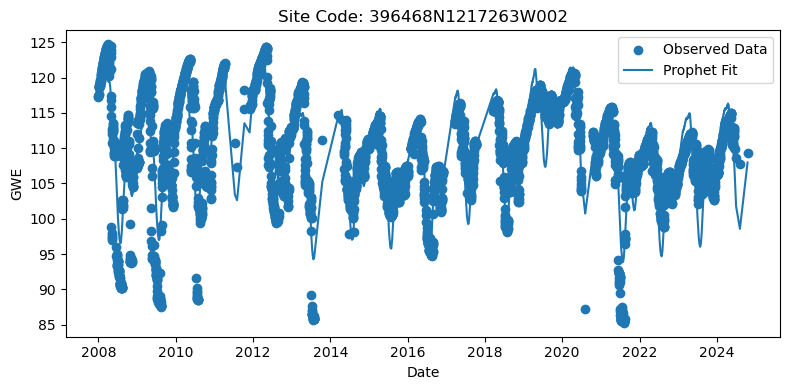

12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


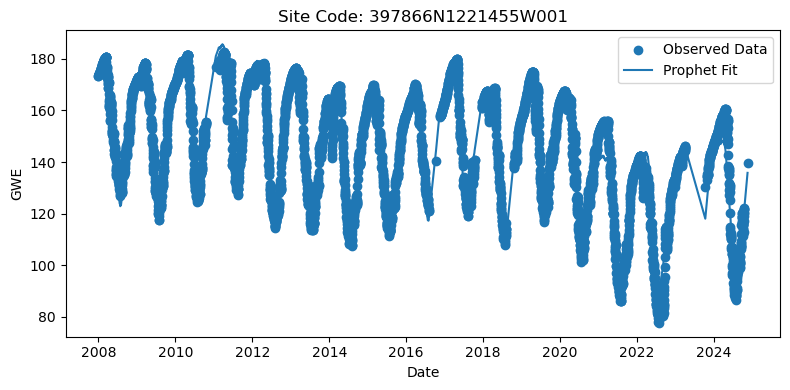

12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


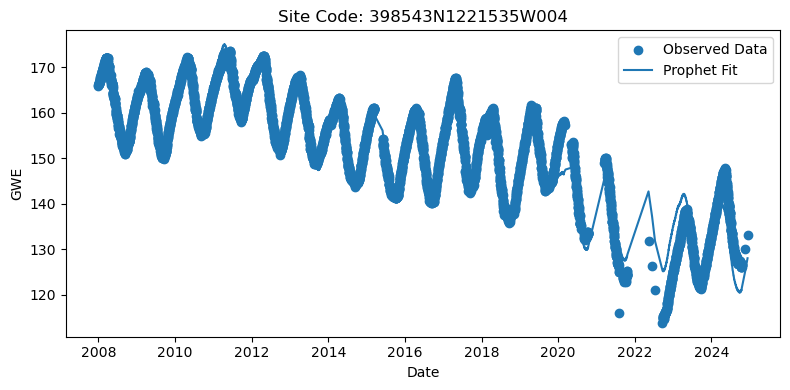

In [13]:
plot_random_prophet_interpolations(data_dict)